# 03 | Evaluate CARAVAN Snow Model

## Purpose
Evaluate the trained LSTM model on the CARAVAN snow-dominated basin dataset.
This notebook covers:
1. Identifying the best training epoch from validation metrics
2. Submitting the evaluation SLURM job across train/validation/test periods
3. Loading and summarizing per-basin evaluation metrics
4. Visualizing model performance — distributions, maps, and example hydrographs

**Prerequisites:**
- `02_neural_hydrology_caravan_setup.ipynb` must have been run and the training
  job must have completed successfully
- The run directory under `results/caravan_snow_global_scenario1/` must exist
  and contain epoch checkpoints and validation metrics

**Outputs produced by this notebook:**
- `evaluate_caravan_snow.slurm` — SLURM evaluation job script
- `results/evaluation_summary.csv` — per-basin metrics for all periods
- Figures saved to `results/` — performance distributions, maps, hydrographs

**Shared storage:**
- CARAVAN data: `/uufs/chpc.utah.edu/common/home/johnsonrc-group1/CARAVAN/CARAVAN_data`
- Project directory: `/uufs/chpc.utah.edu/common/home/civil-group1/Meyer/neuralhydrology_project`

> **Note for new users:** Update `PROJECT_DIR` in Cell 2 to match your own
> project directory. All other paths are derived from it automatically.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path

# ── Project paths ──────────────────────────────────────────────────────────────
PROJECT_DIR      = Path("/uufs/chpc.utah.edu/common/home/civil-group1/Meyer/neuralhydrology_project")
CARAVAN_DATA_DIR = Path("/uufs/chpc.utah.edu/common/home/johnsonrc-group1/CARAVAN/CARAVAN_data")

# ── Verify directories exist ───────────────────────────────────────────────────
assert PROJECT_DIR.exists(),      f"Project directory not found: {PROJECT_DIR}"
assert CARAVAN_DATA_DIR.exists(), f"CARAVAN data not found: {CARAVAN_DATA_DIR}"

# ── Ensure output directories exist ───────────────────────────────────────────
(PROJECT_DIR / "results").mkdir(exist_ok=True)

# ── Auto-detect most recent training run ──────────────────────────────────────
scenario_dir = PROJECT_DIR / 'results' / 'caravan_snow_global_scenario1'
run_dirs     = sorted(scenario_dir.glob('caravan_snow_global_scenario1_*'))

if not run_dirs:
    raise FileNotFoundError(
        f"No run directories found under {scenario_dir}\n"
        f"Make sure training has completed before running this notebook."
    )

RUN_DIR = run_dirs[-1]  # most recent run

print("✓ Paths configured")
print(f"  Project    : {PROJECT_DIR}")
print(f"  CARAVAN    : {CARAVAN_DATA_DIR}")
print(f"  Run dir    : {RUN_DIR}")
print(f"\nAll available runs:")
for d in run_dirs:
    print(f"  {d.name}")

✓ Paths configured
  Project    : /uufs/chpc.utah.edu/common/home/civil-group1/Meyer/neuralhydrology_project
  CARAVAN    : /uufs/chpc.utah.edu/common/home/johnsonrc-group1/CARAVAN/CARAVAN_data
  Run dir    : /uufs/chpc.utah.edu/common/home/civil-group1/Meyer/neuralhydrology_project/results/caravan_snow_global_scenario1/caravan_snow_global_scenario1_1302_132854

All available runs:
  caravan_snow_global_scenario1_1302_132854


## Step 1: Identify the Best Training Epoch

neuralhydrology saves a model checkpoint and validation metrics after every epoch
(because we set `save_weights_every: 1` and `save_validation_results: True` in the
config). This means we can look back at the full training history and select the
epoch that produced the best validation performance rather than just using the final epoch.

### Why not just use the last epoch?
Neural networks can overfit — validation performance may peak at epoch 20 and then
degrade slightly as the model starts memorizing training data. Using the best
validation epoch gives a fairer and more reproducible evaluation.

### Metric used for selection
We use **median NSE** (Nash-Sutcliffe Efficiency) across all validation basins.
NSE measures how much better the model is than a simple mean flow benchmark:

| NSE value | Interpretation |
|---|---|
| 1.0 | Perfect prediction |
| 0.0 | No better than predicting mean flow |
| < 0.0 | Worse than predicting mean flow |

We use the **median** rather than the mean because NSE distributions are often
skewed by a small number of poorly performing basins. The median is more robust
and representative of typical basin performance.

### Where the metrics live
After each validation epoch, neuralhydrology writes a per-basin metrics CSV to:
```
results/
└── caravan_snow_global_scenario1/
    └── caravan_snow_global_scenario1_{timestamp}/
        └── validation/
            ├── model_epoch001/
            │   └── validation_metrics.csv
            ├── model_epoch002/
            │   └── validation_metrics.csv
            └── ...
```
We will read all of these files, extract the median NSE per epoch, and select
the epoch with the highest value.

Validation Median NSE by Epoch:
 Epoch  Median NSE  
----------------------------------------
     1       0.5147  
     2      -0.0161  
     3       0.7168  
     4      -0.9315  
     5       0.7013  
     6       0.5749  
     7       0.3876  
     8      -7.4734  
     9       0.8282   ← best
    10      -0.9154  
    11       0.6154  
    12       0.6361  
    13       0.6681  
    14       0.6071  
    15       0.6091  
    16       0.5663  
    17       0.5184  
    18      -0.1308  
    19       0.6748  
    20       0.6545  
    21       0.6744  
    22       0.3505  
    23       0.4646  
    24       0.5646  
    25       0.4774  
    26       0.5512  
    27       0.6506  
    28       0.5906  
    29       0.5599  
    30       0.6129  

✓ Best epoch : 9
  Median NSE : 0.8282
  Run dir    : /uufs/chpc.utah.edu/common/home/civil-group1/Meyer/neuralhydrology_project/results/caravan_snow_global_scenario1/caravan_snow_global_scenario1_1302_132854


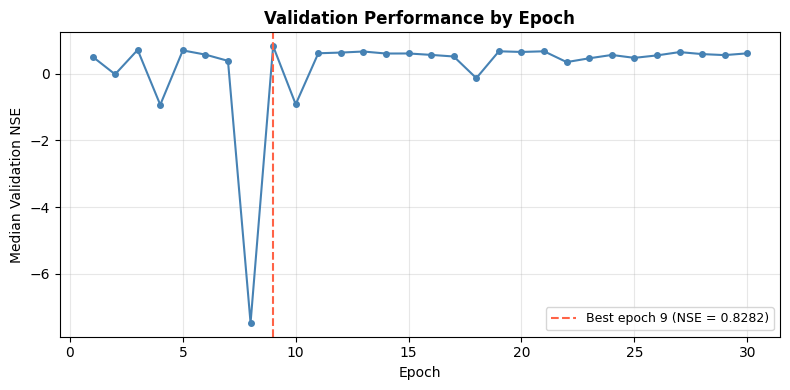


✓ Saved: results/validation_nse_curve.png


In [2]:
# ── Read validation metrics for every epoch ────────────────────────────────────
validation_dir = RUN_DIR / 'validation'
epoch_results  = {}

for epoch_dir in sorted(validation_dir.glob('model_epoch*')):
    metrics_file = epoch_dir / 'validation_metrics.csv'
    if not metrics_file.exists():
        continue

    epoch_num = int(epoch_dir.name.replace('model_epoch', ''))
    df        = pd.read_csv(metrics_file)

    if 'NSE' not in df.columns:
        print(f"  WARNING: No NSE column in epoch {epoch_num}, skipping")
        continue

    epoch_results[epoch_num] = df['NSE'].dropna().median()

if not epoch_results:
    raise ValueError(
        "No validation metrics found.\n"
        "Ensure save_validation_results: True was set in the config."
    )

# ── Build summary table ────────────────────────────────────────────────────────
nse_series       = pd.Series(epoch_results, name='Median_NSE').sort_index()
nse_series.index.name = 'Epoch'

print("Validation Median NSE by Epoch:")
print("=" * 40)
print(f"{'Epoch':>6}  {'Median NSE':>10}  {'':}")
print("-" * 40)
for epoch, nse in nse_series.items():
    flag = ' ← best' if epoch == nse_series.idxmax() else ''
    print(f"  {epoch:>4}   {nse:>10.4f}  {flag}")

# ── Select best epoch ──────────────────────────────────────────────────────────
BEST_EPOCH = int(nse_series.idxmax())
BEST_NSE   = nse_series.max()

print(f"\n{'='*40}")
print(f"✓ Best epoch : {BEST_EPOCH}")
print(f"  Median NSE : {BEST_NSE:.4f}")
print(f"  Run dir    : {RUN_DIR}")

# ── Plot training curve ────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(nse_series.index, nse_series.values, marker='o', markersize=4,
        color='steelblue', linewidth=1.5)
ax.axvline(BEST_EPOCH, color='tomato', linewidth=1.5, linestyle='--',
           label=f'Best epoch {BEST_EPOCH} (NSE = {BEST_NSE:.4f})')
ax.set_xlabel('Epoch')
ax.set_ylabel('Median Validation NSE')
ax.set_title('Validation Performance by Epoch', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(PROJECT_DIR / 'results' / 'validation_nse_curve.png',
            dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Saved: results/validation_nse_curve.png")

## Step 2: Submit the Evaluation Job

With the best epoch identified, we now run neuralhydrology's evaluation routine
across all three periods — train, validation, and test. This computes per-basin
metrics (NSE, KGE, MSE, Alpha-NSE, Beta-NSE) and saves predicted vs. observed
timeseries for every basin.

### Why evaluate all three periods?
| Period | Purpose |
|---|---|
| **Train** | Confirms the model learned — poor train performance indicates underfitting |
| **Validation** | Used for epoch selection — already seen during training loop |
| **Test** | Held-out, unbiased estimate of generalization performance |

Comparing train vs. test performance reveals overfitting — if train NSE is much
higher than test NSE, the model has memorized rather than generalized.

### Parallelization across 3 GPUs
Evaluating 3,297 basins × 3 periods is time-consuming on a single GPU. We
parallelize by launching three independent Python processes simultaneously,
each assigned to one period and one GPU:
```
GPU 0  →  test period
GPU 1  →  validation period
GPU 2  →  train period
```

Each process calls `eval_run()` from the neuralhydrology Python API directly,
which avoids any ambiguity in CLI flag names.

### SBATCH directives for evaluation
| Directive | Value | Explanation |
|---|---|---|
| `--ntasks` | `3` | Three parallel evaluation processes |
| `--cpus-per-task` | `8` | CPU cores per process for data loading |
| `--mem` | `96G` | Higher than training — all three periods load data simultaneously |
| `--gres=gpu` | `3` | One GPU per evaluation period |
| `--time` | `12:00:00` | Evaluation is faster than training — 12 hours is sufficient |

### Output location
Results are written to:
```
results/caravan_snow_global_scenario1/{run_dir}/
└── test/
│   └── model_epoch{BEST_EPOCH}/
│       ├── test_metrics.csv          ← per-basin NSE, KGE, MSE etc.
│       └── test_results.p            ← predicted vs. observed timeseries
├── validation/
│   └── model_epoch{BEST_EPOCH}/
└── train/
    └── model_epoch{BEST_EPOCH}/
```

In [3]:
slurm_script = f"""#!/bin/bash
#SBATCH --account=rai
#SBATCH --partition=rai-gpu-grn
#SBATCH --qos=rai-gpu-grn
#SBATCH --nodes=1
#SBATCH --ntasks=3
#SBATCH --cpus-per-task=8
#SBATCH --mem=96G
#SBATCH --gres=gpu:3
#SBATCH --time=12:00:00
#SBATCH --job-name=caravan_snow_eval
#SBATCH --output={PROJECT_DIR}/results/slurm_eval_%j.out
#SBATCH --error={PROJECT_DIR}/results/slurm_eval_%j.err
#SBATCH --mail-type=BEGIN,END,FAIL
#SBATCH --mail-user=kaitlin.meyer@utah.edu

echo "=========================================="
echo "Job ID: $SLURM_JOB_ID"
echo "Node: $SLURM_NODELIST"
echo "Partition: $SLURM_JOB_PARTITION"
echo "GPUs allocated: $SLURM_JOB_GPUS"
echo "Start time: $(date)"
echo "=========================================="

# Load modules
module purge
module load miniconda3/25.9.1
module load cuda/12.1

# Activate environment
source activate neuralhydrology

# Confirm environment
echo "Python: $(which python)"
echo "CUDA available: $(python -c 'import torch; print(torch.cuda.is_available())')"
echo "GPU count: $(python -c 'import torch; print(torch.cuda.device_count())')"
echo ""

# -------------------------------------------------------
# Settings (written by notebook at job-creation time)
# -------------------------------------------------------
RUN_DIR="{RUN_DIR}"
BEST_EPOCH={BEST_EPOCH}

echo "Run directory : $RUN_DIR"
echo "Epoch to eval : $BEST_EPOCH"
echo ""

# -------------------------------------------------------
# Launch 3 evaluation processes in parallel,
# each on its own GPU (cuda:0 = test, cuda:1 = validation,
# cuda:2 = train), using the neuralhydrology Python API
# so there is no ambiguity in CLI flag names.
# -------------------------------------------------------

echo "Launching parallel evaluation across 3 GPUs..."
echo "  GPU 0 -> period: test"
echo "  GPU 1 -> period: validation"
echo "  GPU 2 -> period: train"
echo ""

python - <<'PYEOF' &
from pathlib import Path
from neuralhydrology.nh_run import eval_run
print("[GPU 0 / test] Starting...", flush=True)
eval_run(run_dir=Path("{RUN_DIR}"), period="test", epoch={BEST_EPOCH}, gpu=0)
print("[GPU 0 / test] Done.", flush=True)
PYEOF
PID_TEST=$!

python - <<'PYEOF' &
from pathlib import Path
from neuralhydrology.nh_run import eval_run
print("[GPU 1 / validation] Starting...", flush=True)
eval_run(run_dir=Path("{RUN_DIR}"), period="validation", epoch={BEST_EPOCH}, gpu=1)
print("[GPU 1 / validation] Done.", flush=True)
PYEOF
PID_VAL=$!

python - <<'PYEOF' &
from pathlib import Path
from neuralhydrology.nh_run import eval_run
print("[GPU 2 / train] Starting...", flush=True)
eval_run(run_dir=Path("{RUN_DIR}"), period="train", epoch={BEST_EPOCH}, gpu=2)
print("[GPU 2 / train] Done.", flush=True)
PYEOF
PID_TRAIN=$!

# Wait for all three and capture exit codes
wait $PID_TEST;  EXIT_TEST=$?
wait $PID_VAL;   EXIT_VAL=$?
wait $PID_TRAIN; EXIT_TRAIN=$?

echo ""
echo "=========================================="
echo "Evaluation exit codes:"
echo "  test       : $EXIT_TEST"
echo "  validation : $EXIT_VAL"
echo "  train      : $EXIT_TRAIN"
echo "Job completed at: $(date)"
echo "=========================================="

# Exit non-zero if any period failed
if [ $EXIT_TEST -ne 0 ] || [ $EXIT_VAL -ne 0 ] || [ $EXIT_TRAIN -ne 0 ]; then
    echo "ERROR: One or more evaluation periods failed!"
    exit 1
fi
exit 0
"""

# ── Write SLURM script ─────────────────────────────────────────────────────────
slurm_file = PROJECT_DIR / 'evaluate_caravan_snow.slurm'
with open(slurm_file, 'w') as f:
    f.write(slurm_script)

print(f"✓ SLURM script written: {slurm_file}")
print(f"\nKey settings:")
print(f"  Run dir    : {RUN_DIR}")
print(f"  Best epoch : {BEST_EPOCH}")
print(f"  Median NSE : {BEST_NSE:.4f}")
print(f"\nTo submit:")
print(f"  cd {PROJECT_DIR}")
print(f"  sbatch evaluate_caravan_snow.slurm")
print(f"\nTo monitor:")
print(f"  squeue -u $USER")
print(f"  tail -f results/slurm_eval_<JOBID>.out")

✓ SLURM script written: /uufs/chpc.utah.edu/common/home/civil-group1/Meyer/neuralhydrology_project/evaluate_caravan_snow.slurm

Key settings:
  Run dir    : /uufs/chpc.utah.edu/common/home/civil-group1/Meyer/neuralhydrology_project/results/caravan_snow_global_scenario1/caravan_snow_global_scenario1_1302_132854
  Best epoch : 9
  Median NSE : 0.8282

To submit:
  cd /uufs/chpc.utah.edu/common/home/civil-group1/Meyer/neuralhydrology_project
  sbatch evaluate_caravan_snow.slurm

To monitor:
  squeue -u $USER
  tail -f results/slurm_eval_<JOBID>.out


## Next Steps

This notebook has completed the pre-evaluation setup:

1. ✓ **Best epoch identified** — see Cell 4 output for epoch number and median validation NSE
2. ✓ **Evaluation SLURM script written** — `evaluate_caravan_snow.slurm`
3. ✓ **Job ready to submit**